# Importe de Librerias

In [162]:
import numpy as np 
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.graph_objects as go
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report , f1_score, recall_score, precision_score, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer,f1_score
from sklearn.ensemble import VotingClassifier, StackingRegressor
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


# Ensambles de modelos

## Preparamos los datasets para trabajar

In [62]:
ds_train = pd.read_csv('properati_argentina_train.csv')
ds_test = pd.read_csv('properati_argentina_test.csv')

In [63]:
ds_train.head()

,Unnamed: 0,id,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q
0,0,CLj2GNCsBreAzTKFXCaLIQ==,-34.601807,-58.469965,Departamento,2.0,1.0,53.0,49.0,80000.0,bajo
1,1,TvqKIPzzT1urYfVhh8tC7w==,-34.580088,-58.424965,Departamento,2.0,1.0,35.0,35.0,79900.0,medio
2,2,QRs3RUjw1RS5/WRne8ApbA==,-34.551481,-58.452358,Departamento,1.0,1.0,25.0,20.0,69000.0,medio
3,3,ju90QBsV36i7DCOOWCJpaA==,-34.632290,-58.464844,Departamento,5.0,3.0,75.0,75.0,150000.0,medio
4,4,uxD4SK3jtGbmxfIlN03UMQ==,-34.549279,-58.463074,Departamento,2.0,1.0,46.0,34.0,85000.0,bajo


In [64]:
ds_test.head()

,Unnamed: 0,id,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q
0,0,1MIZ1gFNRkTXELdcBl+opQ==,-34.598679,-58.499717,Departamento,1.0,1.0,38.0,28.0,85000.0,medio
1,1,hi5vMb1IpzsBoUGGVGPCXA==,-34.574987,-58.420611,Departamento,2.0,1.0,150.0,70.0,520000.0,alto
2,2,f57uQb0jzaTRg98/B71HOg==,-34.586527,-58.398279,Departamento,2.0,1.0,43.0,41.0,87000.0,medio
3,3,gsO2peJbSoSQ0hI1E5TH8g==,-34.577647,-58.406064,Departamento,4.0,3.0,130.0,118.0,690000.0,alto
4,4,4cnMe44uQLFiAnBC1SXjUg==,-34.560998,-58.464248,Departamento,1.0,1.0,33.0,29.0,95000.0,alto


Elimino columnas 

- id no aporta nada en esta seccion del TP
- Unnamed: 0 

In [65]:
columnas_a_eliminar = ["id", "Unnamed: 0"]

ds_train.drop(columns = columnas_a_eliminar, inplace=True)
ds_test.drop(columns = columnas_a_eliminar, inplace=True)

#cambio nombre a precioxm2_relativo_q
ds_train.rename(columns={"precioxm2_relativo_q":"tipo_precio"}, inplace=True)
ds_test.rename(columns={"precioxm2_relativo_q":"tipo_precio"}, inplace=True)

#### Ingenieria de caracteristicas

Realizo dummies a la variable prperty_type

In [66]:
ds_train = pd.get_dummies(ds_train, columns=["property_type"], drop_first=True)
ds_test =  pd.get_dummies(ds_test, columns=["property_type"], drop_first=True)

Normalizo valores variables cantitativas

In [67]:
columnas_elegidas = ['property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered", "latitud", "longitud"]
sc = StandardScaler()

#estandarizo variables cuantitativas en train
x = ds_train.loc[:, columnas_elegidas].values
x = sc.fit_transform(x)
ds_train[columnas_elegidas] = x 

#estandarizo variables cuantitativas en test
y = ds_test.loc[:, columnas_elegidas].values
y = sc.transform(y)
ds_test[columnas_elegidas] = y


In [68]:
ds_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,-0.226971,-0.843338,-0.572024,-0.901181,-0.360814,-0.422360,80000.0,bajo,1,0
1,0.613885,0.359192,-0.572024,-0.901181,-0.611332,-0.761908,79900.0,medio,1,0
2,1.721401,-0.372818,-1.448310,-0.901181,-0.750509,-1.125710,69000.0,medio,1,0
3,-1.407153,-0.706479,2.056835,1.409468,-0.054625,0.208230,150000.0,medio,1,0
4,1.806656,-0.659172,-0.572024,-0.901181,-0.458238,-0.786162,85000.0,bajo,1,0


In [69]:
ds_test.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,-0.105881,-1.638376,-1.448310,-0.901181,-0.569579,-0.931682,85000.0,medio,1,0
1,0.811376,0.475542,-0.572024,-0.901181,0.989200,0.086963,520000.0,alto,1,0
2,0.364577,1.072312,-0.572024,-0.901181,-0.499991,-0.616388,87000.0,medio,1,0
3,0.708381,0.864258,1.180548,1.409468,0.710847,1.251129,690000.0,alto,1,0
4,1.352950,-0.690547,-1.448310,-0.901181,-0.639168,-0.907429,95000.0,alto,1,0


## Voting

Para voting voy a utilizar 3 modelos de clasificacion.
- Arbol de decisicion
- Random forest
- KNN

### Arbol de decision

In [70]:
features = ["latitud", "longitud", 'property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered", "property_type_Departamento", "property_type_PH"]

target = ["tipo_precio"]

In [71]:
#train
x_train = ds_train[features]
y_train = ds_train[target]

#test
x_test= ds_test[features]
y_test= ds_test[target]

#### Optimizacion de Hiperparametros

In [72]:
def optimizar_parametros(ds_train_x, ds_train_y):
    #Cantidad de combinaciones que quiero porbar
    n=20 

    #Conjunto de parámetros que quiero usar
    params_grid = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(12,20)),
                'ccp_alpha':np.linspace(0.001,0.005,n), 
                'max_depth':list(range(2,10))}
                    
    #Cantidad de splits para el Cross Validation
    folds=10

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    #Clasificador
    base_tree = DecisionTreeClassifier() 

    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score, average='micro')

    #Random Search Cross Validation
    randomcv = RandomizedSearchCV(estimator=base_tree,
                                param_distributions = params_grid,
                                scoring=scorer_fn,
                                cv=kfoldcv,
                                n_iter=n,
                                random_state=1) 


    return randomcv.fit(ds_train_x,ds_train_y)

randomcv_normal = optimizar_parametros(x_train, y_train)

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar f1-score dado que combina las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones


In [73]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_normal.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_normal.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'min_samples_split': 17, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy', 'ccp_alpha': 0.002263157894736842}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.5750308871072931


In [74]:
best_tree = randomcv_normal.best_estimator_

### Random Forest

#### Optimizacon de parametros

In [75]:
def optimizar_parametros_rf(ds_train_x, ds_train_y):
    
    #Cantidad de combinaciones que quiero porbar
    n=20


    param_grid_rf = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(12,20)),
                'ccp_alpha':np.linspace(0.001,0.005,n), 
                'max_depth':list(range(2,10))}

    #Cantidad de splits para el Cross Validation
    folds=10

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    #Clasificador
    base_tree_rf = RandomForestClassifier()#n_estimators=648


    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score, average='micro')

    randomcv_rf = RandomizedSearchCV(   estimator=base_tree_rf,
                                        param_distributions = param_grid_rf,
                                        cv=kfoldcv,
                                        scoring = scorer_fn,
                                        n_jobs=-1,
                                        random_state=1)

    return randomcv_rf.fit(ds_train_x, ds_train_y)



randomcv_rf_normal = optimizar_parametros_rf(x_train, y_train)

c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar f1-score dado que combina las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones


In [76]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_rf_normal.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_rf_normal.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'min_samples_split': 17, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy', 'ccp_alpha': 0.002263157894736842}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.5668263993901306


In [77]:
best_rand_forest = randomcv_rf_normal.best_estimator_

### Knn

#### Optimizacion de parametros

In [78]:
def optimizar_parametros_knn(ds_train_x, ds_train_y): 

    #Grilla de Parámetros
    params_grid={ 'n_neighbors':range(10,30), 
                'weights':['distance','uniform'],
                'algorithm':['ball_tree', 'kd_tree', 'brute'],
                'metric':['euclidean','manhattan','chebyshev']
                }

    scorer_fn = make_scorer(f1_score, average='micro')

    #Clasificador KNN
    knn = KNeighborsClassifier()

    #Random Search con 10 Folds y 10 iteraciones
    rand = RandomizedSearchCV(knn, params_grid, scoring=scorer_fn, cv=10, n_iter=10, random_state=1)

    return rand.fit(ds_train_x, ds_train_y)

randcv_knn = optimizar_parametros_knn(x_train, y_train)


c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was 

- Utilizamos Random Serch dado que si bien Grid search es capaz de encontrar todas las combinaciones, el tiempo de ejecucion es demasiado alto y ademas las metricas no mejoran radicalmente. Utilizo una cantidad de 10 combinaciones

- Para buscar los parametros consideramos utilizar f1-score dado que combina las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones


In [79]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randcv_knn.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randcv_knn.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'weights': 'distance', 'n_neighbors': 29, 'metric': 'manhattan', 'algorithm': 'brute'}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.7258278970424856


In [80]:
best_knn = KNeighborsClassifier().set_params(**randcv_knn.best_params_)

### Ensamblamos los modelos

In [81]:
#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('arbol', best_tree), ('rand_forest', best_rand_forest), ('knn', best_knn)], voting = 'soft')
# soft da una mejora significativas en las metricas

#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)

c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


#### Evaluo

In [82]:
def evaluar_modelo(ds_test_x, ds_test_y, knn):

    y_pred=knn.predict(ds_test_x)

    print('F1-Score: {}'.format(f1_score(ds_test_y, y_pred, average='micro'))) #binary considera la clase positiva por defecto 1
    #Reporte de Clasificación
    print(classification_report(ds_test_y,y_pred))

    #Matriz de Confusión
    cm = confusion_matrix(ds_test_y, y_pred)
    sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')

F1-Score: 0.7265565288964665
              precision    recall  f1-score   support

        alto       0.79      0.59      0.67      4252
        bajo       0.79      0.61      0.69      4265
       medio       0.69      0.85      0.76      8492

    accuracy                           0.73     17009
   macro avg       0.76      0.68      0.71     17009
weighted avg       0.74      0.73      0.72     17009



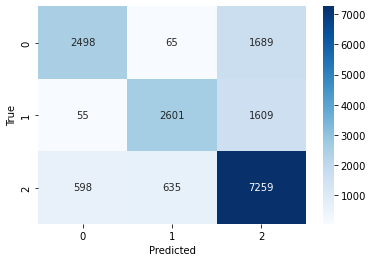

In [83]:
evaluar_modelo( x_test, y_test, vot_clf)

In [84]:
acc = accuracy_score(y_test, pred)
pre = precision_score(y_test, pred, average="macro")
rec = recall_score(y_test, pred, average="macro")
f1 = f1_score(y_test, pred, average='macro')

print("La metrica Accuracy con datos de testeo fue de: " + str(acc))
print("La metrica Precision con datos de testeo fue de: " + str(pre))
print("La metrica Recall con datos de testeo fue de: " + str(rec))
print("La metrica F1 con datos de testeo fue de: " + str(f1))

La metrica Accuracy con datos de testeo fue de: 0.7265565288964666
La metrica Precision con datos de testeo fue de: 0.7561026311748046
La metrica Recall con datos de testeo fue de: 0.6840467864827603
La metrica F1 con datos de testeo fue de: 0.7081836171081927


### Comparacion con Redes Neuronales

ver despues

## Stacking

#### Preparamos los datasets a utilizar

In [85]:
features = ["latitud", "longitud", 'property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered", "property_type_Departamento", "property_type_PH"]

target = ["property_price"]

In [86]:
#train
x_train = ds_train[features]
y_train = ds_train[target]

#test
x_test= ds_test[features]
y_test= ds_test[target]

### Knn

In [121]:
#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev', 'minkowski'],
              'leaf_size': list(range(0, 50)),
             }

#Metrica que quiero optimizar 
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)
#Clasificador KNN
knn=KNeighborsRegressor()

#Random Search con 5 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring = {"mean_squared_error":scorer_fn, "r2" :scorer_fn2}, n_iter=10, random_state=5, refit='r2')
rand.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsRegressor(),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'leaf_size': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9, 10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, ...],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev', 'minkowski'],
                                        'n_neighbors': range(1, 30),
                                        'weights': ['distance', 'uniform']},
                   random_state=5, refit='r2',
                   scoring={'mean_squared_error': make_scorer(mea

In [111]:
#Mejores hiperparametros
print(rand.best_params_)

#Mejor métrica
r2 = rand.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))


{'weights': 'distance', 'n_neighbors': 22, 'metric': 'manhattan', 'leaf_size': 44, 'algorithm': 'brute'}
El R2 score en datos de entrnamiento: 0.8933312441545171


In [169]:
#Mejor estimador
best_knn_regr = rand.best_estimator_
y_pred = best_knn_regr.predict(x_test)

In [119]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

r2 = metrics.r2_score(
        y_true  = y_test,
        y_pred  = y_pred,

)

print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")
print("El R2 score en datos de test: " + str((r2)))


El error (mse) de test es: 2157793016.0353475
El error (rmse) de test es: 46452.05071937457
El R2 score en datos de test: 0.894847987315855


### XGboost

In [122]:
#Cantidad de combinaciones que quiero porbar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'max_depth':list(range(3,10)),                    
               'random_state':list(range(0,6)),                
               'gamma':list(range(10,32)),
               'min_child_weight':list(range(10,18)),
               'colsample_bytree':np.linspace(0.75,0.8,15)}
                
#Cantidad de splits para el Cross Validation
folds=8

#Regresor
xgb_model_rd_search = xgb.XGBRegressor()

#Metrica que quiero optimizar 
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=xgb_model_rd_search,
                              param_distributions = params_grid,
                              scoring = {"mean_squared_error":scorer_fn, "r2" :scorer_fn2},
                              n_iter=n, cv=folds, random_state=5, refit='r2') 


#Busco los hiperparamtros que optimizan MSE y R2
randomcv.fit(x_train,y_train)

[17:58:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "ccp_alpha", "criterion" } are not used.

[17:58:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "ccp_alpha", "criterion" } are not used.

[17:58:05] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "ccp_alpha", "criterion" } are not used.

[17:58:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "ccp_alpha", "criterion" } are not used.

[17:58:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:76

RandomizedSearchCV(cv=8,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
       0.78571429, 0.78928571, 0.79285714, 0.79642857, 0.8       ]),
                                      

In [125]:
#Mejores hiperparametros
print(randomcv.best_params_)

#Mejor métrica
r2 = randomcv.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

{'random_state': 4, 'min_child_weight': 16, 'max_depth': 9, 'gamma': 20, 'criterion': 'entropy', 'colsample_bytree': 0.775, 'ccp_alpha': 0.07142857142857142}
El R2 score en datos de entrnamiento: 0.8892205035685072


In [170]:
#Mejor estimador
best_xgboost_regr = randomcv.best_estimator_
y_pred = best_xgboost_regr.predict(x_test)

In [129]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

r2 = metrics.r2_score(
        y_true  = y_test,
        y_pred  = y_pred,

)

print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")
print("El R2 score en datos de test: " + str((r2)))


El error (mse) de test es: 2162413366.2917895
El error (rmse) de test es: 46501.756593614715
El R2 score en datos de test: 0.8946228317401533


### Gradient boost

In [135]:
#Cantidad de combinaciones que quiero porbar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {         'n_estimators': [50, 100], #nº de etapas de boosting
                        'learning_rate': [0.01, 0.05, 0.1], #reduce la contribucion de cada arbol por este valor 
                        'max_features': [4, 7], #nº de variables a tener en cuenta para las divisiones
                        'min_samples_split': [5, 10]} #nº mínimo de observaciones necesarias para dividir un nodo interno (n.minobsinnode en R)

                
#Cantidad de splits para el Cross Validation
folds=10

#Regresor
gb_model_rd_search = GradientBoostingRegressor()

#Metrica que quiero optimizar 
scorer_fn = make_scorer(mean_squared_error)
scorer_fn2 = make_scorer(r2_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=gb_model_rd_search,
                              param_distributions = params_grid,
                              scoring = {"mean_squared_error":scorer_fn, "r2" :scorer_fn2},
                              n_iter=n, cv=folds, random_state=5, refit="r2") 


#Busco los hiperparamtros que optimizan MSE y R2
randomcv.fit(x_train,y_train)

c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_features': [4, 7],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 100]},
                   random_state=5, refit='r2',
                   scoring={'mean_squared_error': make_scorer(mean_squared_error),
                            'r2': make_scorer(r2_score)})

In [132]:
#Mejores hiperparametros
print(randomcv.best_params_)

#Mejor métrica
r2 = randomcv.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

{'n_estimators': 100, 'min_samples_split': 10, 'max_features': 7, 'learning_rate': 0.1}
El R2 score en datos de entrnamiento: 0.8342981807549025


In [171]:
#Mejor estimador
best_gradient_boost_regr = randomcv.best_estimator_
y_pred = best_gradient_boost_regr.predict(x_test)

In [134]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

r2 = metrics.r2_score(
        y_true  = y_test,
        y_pred  = y_pred,

)

print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")
print("El R2 score en datos de test: " + str((r2)))


El error (mse) de test es: 3370599074.7120585
El error (rmse) de test es: 58056.86070321111
El R2 score en datos de test: 0.8357463973497801


### Random Forest

In [157]:
#Cantidad de combinaciones que quiero porbar
n=10


param_grid_rf = {
            'min_samples_leaf':list(range(1,10)),
            'min_samples_split': list(range(12,20)),
            'max_features': [4, 7],
            'ccp_alpha':np.linspace(0.001,0.005,n), 
            'max_depth':list(range(2,10)),
           }

#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree_rf = RandomForestRegressor()


#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(r2_score)
scorer_fn2 = make_scorer(mean_squared_error)


randomcv_rf = RandomizedSearchCV(   estimator=base_tree_rf,
                                    param_distributions = param_grid_rf,
                                    cv=kfoldcv,
                                    scoring = {"mean_squared_error":scorer_fn, "r2" :scorer_fn2},
                                    n_jobs=-1,
                                    random_state=1,
                                    refit="r2")

randomcv_rf.fit(x_train, y_train)

c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.001     , 0.00144444, 0.00188889, 0.00233333, 0.00277778,
       0.00322222, 0.00366667, 0.00411111, 0.00455556, 0.005     ]),
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'max_features': [4, 7],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [12, 13, 14, 15,
                                                              16, 17, 18, 19]},
                   random_state=1, refit='r2',
                   scoring={'mean_squared_error': make_scorer(r2_score),
                            'r2': make_scorer(mean_squared_error)})

In [158]:
#Mejores hiperparametros
print(randomcv_rf.best_params_)

#Mejor métrica
r2 = randomcv_rf.best_score_

print("El R2 score en datos de entrnamiento: " + str((r2)))

{'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 7, 'max_depth': 3, 'ccp_alpha': 0.001}
El R2 score en datos de entrnamiento: 6510328127.875308


In [172]:
#Mejor estimador
best_rand_forest_regr = randomcv_rf.best_estimator_
y_pred = best_rand_forest.predict(x_test)

In [161]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

r2 = metrics.r2_score(
        y_true  = y_test,
        y_pred  = y_pred,

)

print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")
print("El R2 score en datos de test: " + str((r2)))


El error (mse) de test es: 5960977948.040662
El error (rmse) de test es: 77207.36977802483
El R2 score en datos de test: 0.7095139227237114


### Ensamblamos los modelos

In [176]:
#Modelos Base
base_models = [('random_forest',best_rand_forest_regr),
               ('xg_boost', best_xgboost_regr),
               ('gradient_boost', best_gradient_boost_regr)]

#Meta Modelo
meta_model = best_knn_regr

#Ensemble Stacking
stacking_model = StackingRegressor(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=10,
                                    verbose=2)
#Entreno el ensemble
stacking_model.fit(x_train, y_train)

#Evaluo en conjunto de test
y_pred = stacking_model.predict(x_test)          

c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   35.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   54.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   54.7s finished


In [177]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

r2 = metrics.r2_score(
        y_true  = y_test,
        y_pred  = y_pred,

)

print(f"El error (mse) de test es: {mse}")
print(f"El error (rmse) de test es: {rmse}")
print("El R2 score en datos de test: " + str((r2)))

El error (mse) de test es: 3410293298.9781146
El error (rmse) de test es: 58397.71655619862
El R2 score en datos de test: 0.8338120470471821


### Comparacion con lo obtenido en redes

a completar !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!